<a href="https://colab.research.google.com/github/munevardo/aprendizaje_automatico_final/blob/main/Segementacion_clientes_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**SEGMENTACIÓN DE CLIENTES**

####**Grupo 9**
*   Jose Luis Munévar Diaz
*   Angie Catherine Collazos Valenzuela
*   Iván Valderrama Corredor


####**Introducción**


En este trabajo se utiliza la base de datos Online Retail del repositorio UCI Machine Learning, que contiene más de 500 mil transacciones realizadas por una empresa de ventas en línea de Reino Unido entre 2010 y 2011. El objetivo del análisis es explorar técnicas de aprendizaje no supervisado aplicadas a la segmentación de clientes, con el fin de identificar patrones de compra que puedan ser útiles en la toma de decisiones estratégicas. Para ello, se plantearon diferentes hipótesis en torno a modelos de clustering como KMeans, clustering jerárquico y métodos basados en densidad (DBSCAN), evaluando sus supuestos, ventajas y limitaciones frente a la naturaleza de los datos. Posteriormente, se seleccionó una de las hipótesis más adecuadas para el contexto del dataset y se realizaron procesos de preparación y transformación de la base de datos —incluyendo la detección de outliers, transformaciones logarítmicas y estandarización— con el fin de asegurar que los modelos de agrupamiento trabajen con información más robusta y homogénea. Finalmente, se procederá a aplicar el modelo elegido para contrastar la hipótesis planteada y evaluar la calidad de los grupos obtenidos.

####**Entendimiento de los datos**




In [21]:
import pandas as pd
import numpy as np
import pandas as pd
from google.colab import files


url = "https://github.com/munevardo/aprendizaje_automatico_final/raw/442a507903422b3bb278084e5b500b065af4b9f7/data/Online%20Retail.xlsx"

df = pd.read_excel(url)

# 2. Información general
print("=== Info general ===")
print(df.info())

print("\n=== Primeras filas ===")
print(df.head())



=== Info general ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

=== Primeras filas ===
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HE

In [22]:

# 3. Estadísticas descriptivas
print("\n=== Estadísticas descriptivas numéricas ===")
print(df.describe())

print("\n=== Estadísticas categóricas ===")
print(df.describe(include="object"))



=== Estadísticas descriptivas numéricas ===
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  

=== Estadísticas categóricas ===
        InvoiceNo StockCode                         Description  \
count      54190

In [23]:
# 4. Valores faltantes
print("\n=== Valores faltantes por columna ===")
print(df.isnull().sum())


=== Valores faltantes por columna ===
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [24]:
# 5. Variables categóricas y numéricas
categoricas = df.select_dtypes(include=["object"]).columns.tolist()
numericas = df.select_dtypes(exclude=["object"]).columns.tolist()

print("\nVariables categóricas:", categoricas)
print("Variables numéricas:", numericas)


Variables categóricas: ['InvoiceNo', 'StockCode', 'Description', 'Country']
Variables numéricas: ['Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']


In [25]:
# 6. Unicidad y duplicados
print("\nDuplicados:", df.duplicated().sum())


Duplicados: 5268


####**Análisis**

**Variables numéricas**

Quantity: rango enorme (-80,995 a +80,995) → valores negativos corresponden a devoluciones.

UnitPrice: va desde -11,062 hasta 38,970 → precios negativos no son lógicos, podrían ser errores o devoluciones mal cargadas.

CustomerID: muchos nulos (135,080 ≈ 25% de las filas). Esto limita los análisis a nivel cliente.

InvoiceDate: útil para construir variables como recencia, pero no sirve crudo como predictor.

**Variables categóricas**

InvoiceNo y StockCode: son identificadores, no aportan directamente para clustering.

Description: tiene 1,454 nulos y 4,223 valores únicos → demasiada dispersión para usarla sin procesar.

Country: 38 países, pero United Kingdom domina con 495,478 de 541,909 filas (≈91%).

**Duplicados y nulos**

Hay 5,268 registros duplicados.

25% de CustomerID está vacío → los clientes sin ID no podrían agruparse en un análisis por cliente.

####**Análisis frente a las Hipótesis**

**KMeans**

No viable sobre transacciones individuales (mucho ruido por precios negativos, cantidades extremas).

Viable si se agregan métricas por cliente: gasto total (Quantity × UnitPrice), número de facturas, productos distintos, etc.

Problema: 25% de los registros sin CustomerID no podrán ser considerados en esta hipótesis.

Parámetro crítico: número de clusters.

**Jerárquico**

Imposible con 541k registros (coste computacional).

Factible al reducir a clientes únicos con ID (≈4,000 clientes).

Los nulos en CustomerID implican que el análisis jerárquico perdería ese 25% de datos.

Parámetros: tipo de linkage, nivel de corte en el dendrograma.

**DBSCAN**

Con transacciones en crudo sería impracticable (muchísimos puntos, densidad muy heterogénea).

Requiere también agregación por cliente y normalización de las métricas.

La elección de eps y min_samples es crítica y difícil sin exploración previa.

Riesgo: DBSCAN puede marcar demasiados puntos como ruido si la densidad de clientes es muy variable.

####**Conclusiones**

Al analizar el dataset en su estado original, se observa que ninguna de las tres técnicas de clustering propuestas puede aplicarse de manera directa debido a la presencia de devoluciones (cantidades y precios negativos), valores atípicos extremos y un alto porcentaje de registros sin identificador de cliente. En el caso de KMeans, su aplicación sobre transacciones individuales generaría resultados poco fiables, por lo que es indispensable una agregación a nivel de cliente y la normalización de variables. El clustering jerárquico presenta un problema adicional de escalabilidad, ya que resulta impracticable sobre más de medio millón de registros, aunque sí sería viable si se trabaja únicamente con clientes únicos, reduciendo así la muestra a unas pocas miles de observaciones. Por su parte, DBSCAN enfrenta la dificultad de operar sobre un conjunto tan heterogéneo y masivo, lo que produciría un exceso de puntos clasificados como ruido si no se ajustan con precisión los hiperparámetros; nuevamente, solo sería factible después de una agregación por cliente y escalamiento de variables. En síntesis, la viabilidad de estas hipótesis depende de transformar los datos transaccionales en representaciones más compactas y consistentes a nivel de cliente, siendo KMeans y DBSCAN opciones más adecuadas una vez realizados estos pasos, mientras que el jerárquico, aunque interpretable, sigue limitado por el tamaño de los datos.

####**Elección del modelo**
Tras el análisis del dataset, la hipótesis más viable resulta ser la aplicación de un modelo de clustering basado en centroides (KMeans). Esta técnica ofrece un buen balance entre escalabilidad y capacidad de interpretación, ya que puede manejar sin problemas el número de clientes presentes en la base una vez que los datos se agreguen a nivel de cliente, y además permite evaluar objetivamente la calidad de los grupos mediante métricas como el método del codo o el índice de silhouette. En contraste, el clustering jerárquico presenta serias limitaciones debido al volumen de los datos, lo que lo hace impracticable en su estado actual, mientras que DBSCAN, aunque útil para detectar patrones irregulares o clientes atípicos, es altamente sensible a la elección de parámetros y corre el riesgo de generar un alto porcentaje de ruido en una base tan heterogénea. En consecuencia, KMeans se posiciona como la opción más adecuada para este caso, siempre que se realicen previamente la agregación por cliente y la normalización de variables.

###**Hipótesis elegida: KMeans**

Podemos utilizar la fortaleza principal de KMeans, que es la definición del número de clusters, para segmentar a los clientes en 3 a 5 grupos representativos (por ejemplo: Bronce, Plata, Oro y Platino). Esta segmentación busca simplificar la explicación de resultados y aportar al diseño de estrategias comerciales diferenciadas. Para ello, se utilizarán las variables Quantity (cantidad total comprada) y TotalPrice (valor total gastado) como ejes principales, calculando los centroides más precisos que permitan identificar patrones de consumo. La elección de K se realizará apoyándonos en métricas de validación interna como el método del codo y el índice de silhouette, asegurando la calidad de los clusters resultantes.

####**Limpieza de los datos**

In [28]:
# LIMPIEZA PARA HIPÓTESIS KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Eliminar duplicados
df = df.drop_duplicates()

#Eliminar registros con CustomerID nulo (indispensable para agrupar clientes)
df = df.dropna(subset=["CustomerID"])

df.describe


<bound method NDFrame.describe of        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  
0      2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2      2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4      2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
...                    ...        ...         ...             ...  
541904 2011-12-09 12:50:00       0.85     12680.0          France  
541905 2011-12-09 12:50:00       2.10     12680.0          France  
541906 2011-12-09 12:50:00       4.15     12680.0          France  
541907 2011-12-09 12:50:00       4.15     12680.0          France  
541908 2011-12-09 12:50:00       4.95     12680.0          France  

[401604 rows x 8 columns]>

In [29]:
print(df.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


En la etapa de limpieza se decidió eliminar los registros con CustomerID nulo, dado que la hipótesis de segmentación se centra en agrupar clientes y no transacciones individuales. Aunque esta decisión reduce aproximadamente un 25% de las observaciones, se consideró necesaria para garantizar que cada registro pueda asociarse a un cliente único. No obstante, se reconoce como limitación que esta exclusión puede afectar la representatividad de clientes anónimos o no identificados en la base de datos.

In [30]:

# Filtrar registros inválidos (cantidades y precios <= 0)
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

# Crear variable de importe total de la transacción
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]




/tmp/ipython-input-4017138061.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]


En la etapa de limpieza se eliminaron registros con cantidades y precios menores o iguales a cero, pues estos correspondían a devoluciones, cancelaciones o errores de registro que distorsionan el análisis del gasto real de los clientes. Con este filtrado se garantiza que las transacciones reflejen únicamente compras efectivas. Adicionalmente, se creó la variable TotalPrice como el producto de Quantity y UnitPrice, la cual representa el importe total de cada transacción y servirá como variable clave para la segmentación.

In [31]:
# AGREGACIÓN A NIVEL CLIENTE
df_customer = df.groupby("CustomerID").agg({
    "Quantity": "sum",       # Cantidad total de ítems comprados
    "TotalPrice": "sum"      # Total gastado
}).reset_index()

print("\nVista previa de datos a nivel cliente:")
print(df_customer.head())


Vista previa de datos a nivel cliente:
   CustomerID  Quantity  TotalPrice
0     12346.0     74215    77183.60
1     12347.0      2458     4310.00
2     12348.0      2341     1797.24
3     12349.0       631     1757.55
4     12350.0       197      334.40


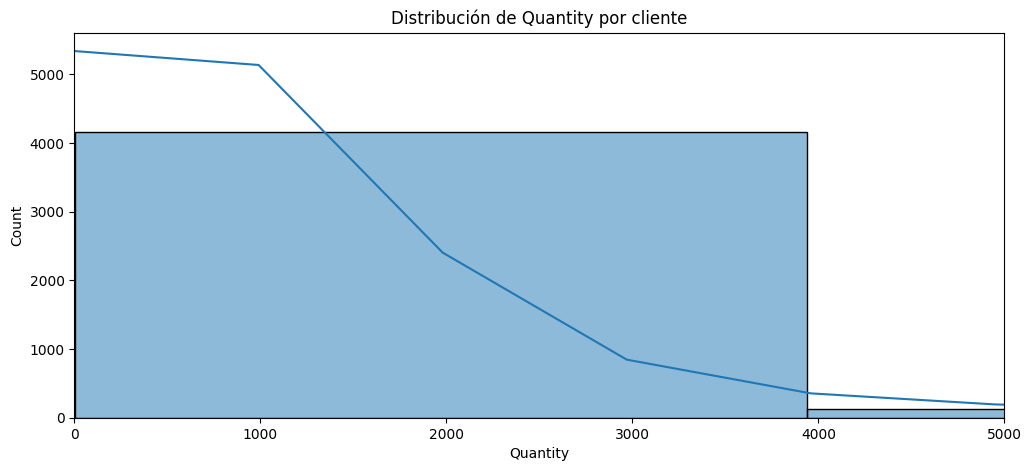

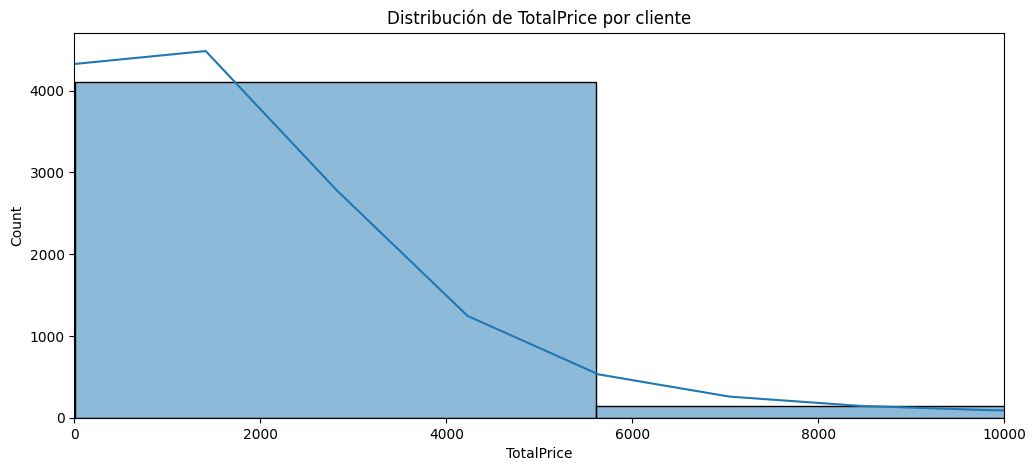

In [32]:
# VISUALIZACIONES INICIALES
plt.figure(figsize=(12,5))
sns.histplot(df_customer["Quantity"], bins=50, kde=True)
plt.title("Distribución de Quantity por cliente")
plt.xlim(0, 5000)  # limitar eje para ver mejor
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df_customer["TotalPrice"], bins=50, kde=True)
plt.title("Distribución de TotalPrice por cliente")
plt.xlim(0, 10000)  # limitar eje para ver mejor
plt.show()



In [33]:
# NORMALIZACIÓN
from sklearn.preprocessing import StandardScaler

X = df_customer[["Quantity", "TotalPrice"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nShape final de X:", X_scaled.shape)


Shape final de X: (4338, 2)


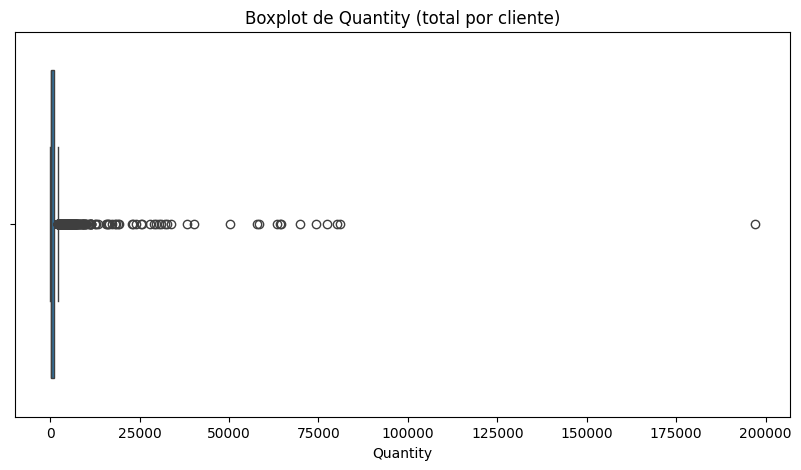

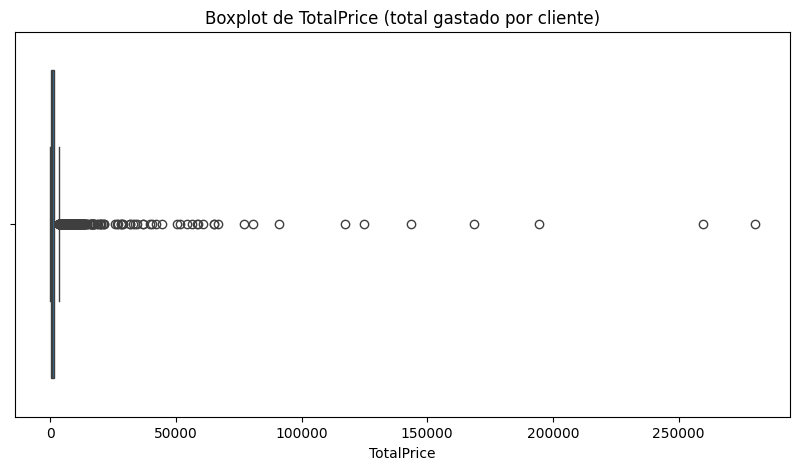

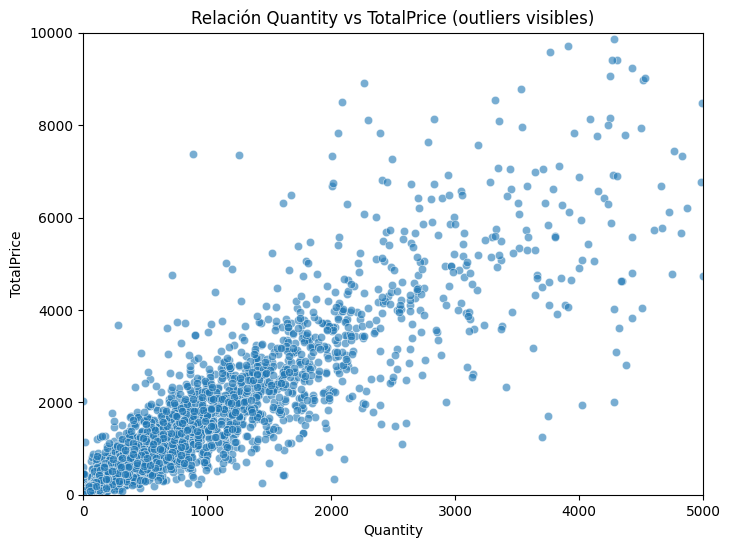

In [34]:
# BOXplots para detectar outliers
plt.figure(figsize=(10,5))
sns.boxplot(x=df_customer["Quantity"])
plt.title("Boxplot de Quantity (total por cliente)")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x=df_customer["TotalPrice"])
plt.title("Boxplot de TotalPrice (total gastado por cliente)")
plt.show()

# También gráfico combinado
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_customer,
    x="Quantity",
    y="TotalPrice",
    alpha=0.6
)
plt.title("Relación Quantity vs TotalPrice (outliers visibles)")
plt.xlim(0, 5000)   # recortar ejes para ver mejor
plt.ylim(0, 10000)
plt.show()


####**Manejo de outliers**

In [35]:

# Aplicar log-transform
df_customer["Quantity_log"] = np.log1p(df_customer["Quantity"])
df_customer["TotalPrice_log"] = np.log1p(df_customer["TotalPrice"])




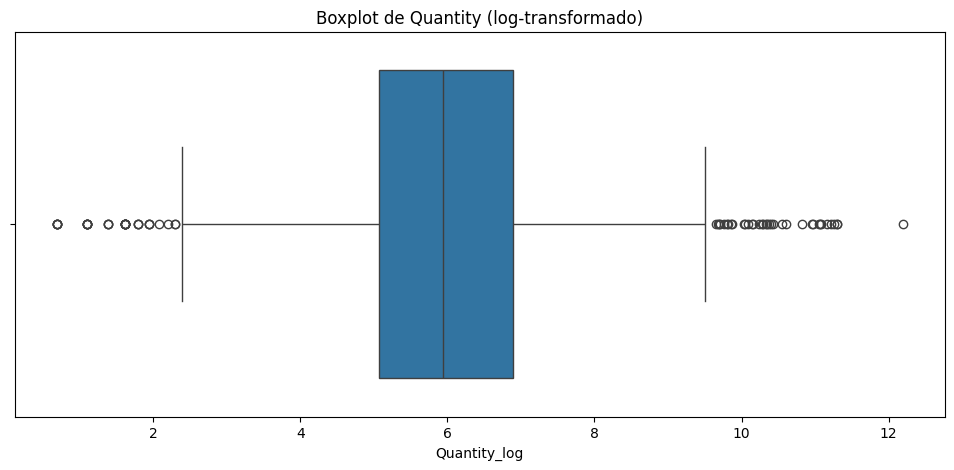

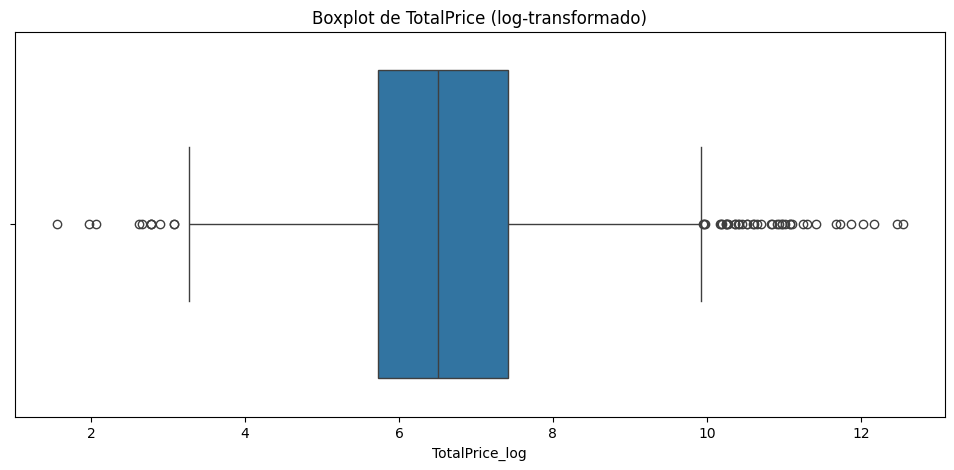

In [36]:
# Boxplots después del log

plt.figure(figsize=(12,5))
sns.boxplot(x=df_customer["Quantity_log"])
plt.title("Boxplot de Quantity (log-transformado)")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x=df_customer["TotalPrice_log"])
plt.title("Boxplot de TotalPrice (log-transformado)")
plt.show()

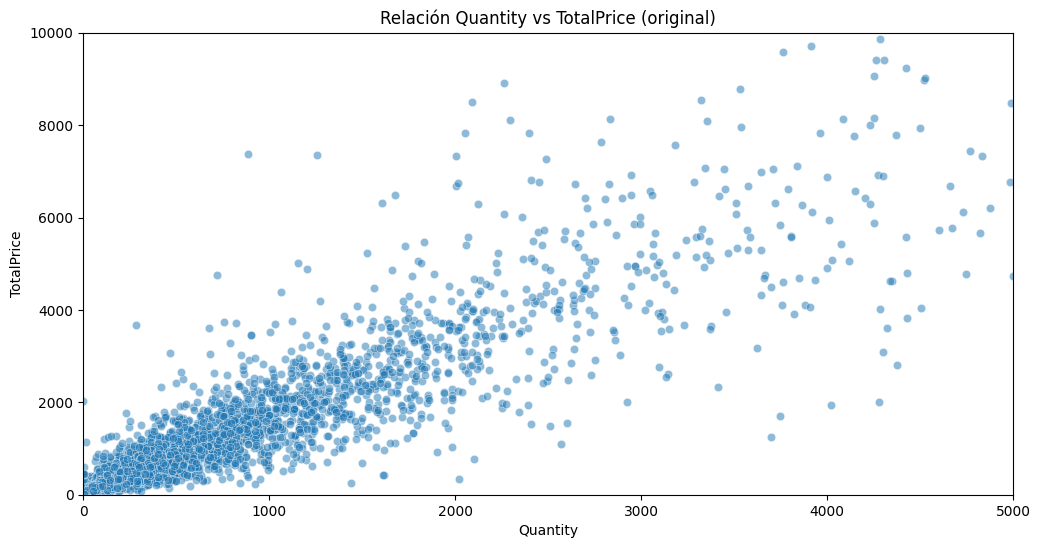

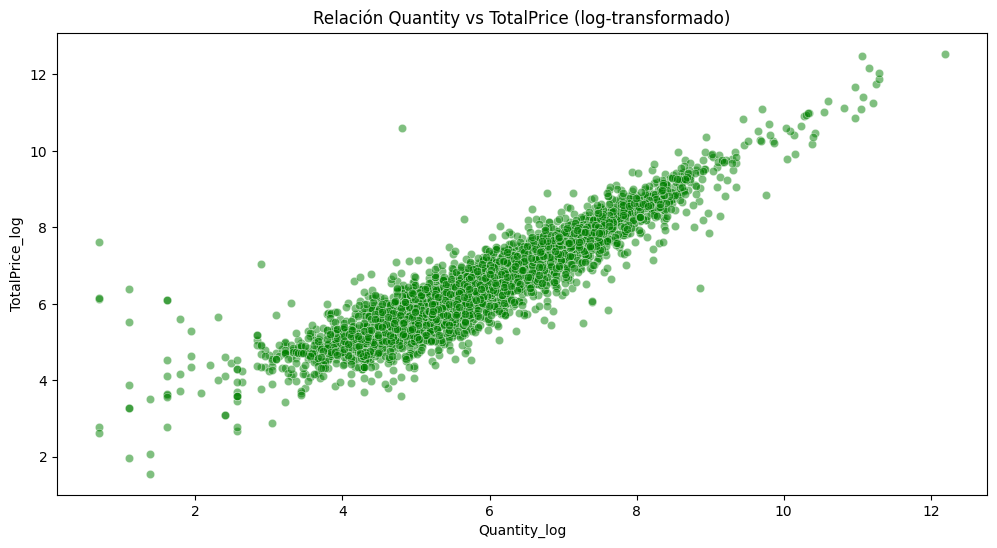

In [37]:
# =========================
# Comparación scatter antes vs después
# =========================
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_customer, x="Quantity", y="TotalPrice", alpha=0.5)
plt.title("Relación Quantity vs TotalPrice (original)")
plt.xlim(0,5000)
plt.ylim(0,10000)
plt.show()

plt.figure(figsize=(12,6))
sns.scatterplot(data=df_customer, x="Quantity_log", y="TotalPrice_log", alpha=0.5, color="green")
plt.title("Relación Quantity vs TotalPrice (log-transformado)")
plt.show()

In [38]:
from sklearn.preprocessing import StandardScaler

# Selección de variables log-transformadas
X_log = df_customer[["Quantity_log", "TotalPrice_log"]]

# Estandarización
scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

print("Shape final de X_log_scaled:", X_log_scaled.shape)


Shape final de X_log_scaled: (4338, 2)


Para el análisis de clustering con KMeans decidimos trabajar con las variables transformadas en logaritmo (Quantity_log y TotalPrice_log), ya que esta transformación permitió reducir la fuerte asimetría y el impacto de los valores atípicos presentes en los datos originales. De esta manera, la distribución de las observaciones se vuelve más compacta y homogénea, lo cual facilita que el algoritmo identifique patrones de comportamiento más claros. Además, tras aplicar la transformación, realizamos una estandarización con StandardScaler para garantizar que ambas variables contribuyan de forma equilibrada al cálculo de las distancias, evitando que la escala de una de ellas domine el proceso de agrupamiento.

Evaluación de

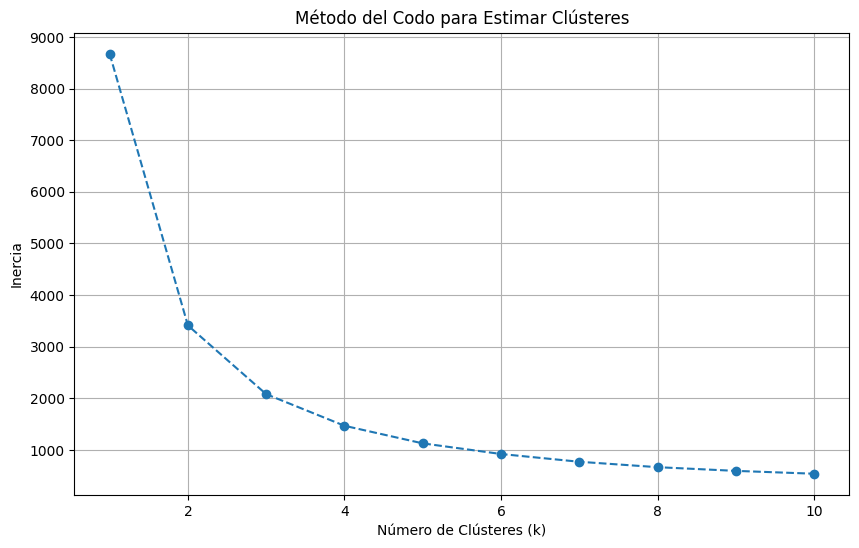

In [43]:
inertia = []
for k in range(1, 11):
    kmeans_model = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans_model.fit(X_log_scaled)
    inertia.append(kmeans_model.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Método del Codo para Estimar Clústeres')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

*  gráfico muestra los resultados del método del codo aplicado al conjunto de datos de clientes. El eje horizontal (X) representa el número de clústeres (k) probados, mientras que el eje vertical (Y) muestra la inercia, que es la suma de las distancias cuadradas de cada punto a su centroide de clúster. La inercia mide la cohesión interna de los clústeres: un valor más bajo indica una mejor agrupación.

* **Observación clave:** Se puede identificar un punto de inflexión significativo, o "codo", en la curva. Este codo es muy evidente en el valor de k=2.

* **Interpretación:** Al pasar de un solo clúster (k=1) a dos clústeres (k=2), se observa la mayor caída en la inercia. Esto significa que la división inicial de los datos en dos grupos produce una mejora drástica en la cohesión interna.

* **Justificación de la elección:** Después del punto k=2, la disminución en la inercia continúa, pero a un ritmo mucho más gradual. Esto sugiere que añadir un tercer, cuarto o quinto clúster no aporta una mejora sustancial al modelo que justifique la complejidad adicional. Un científico de datos busca un equilibrio entre tener una buena cohesión (baja inercia) y mantener el modelo lo más simple posible para facilitar su interpretación.

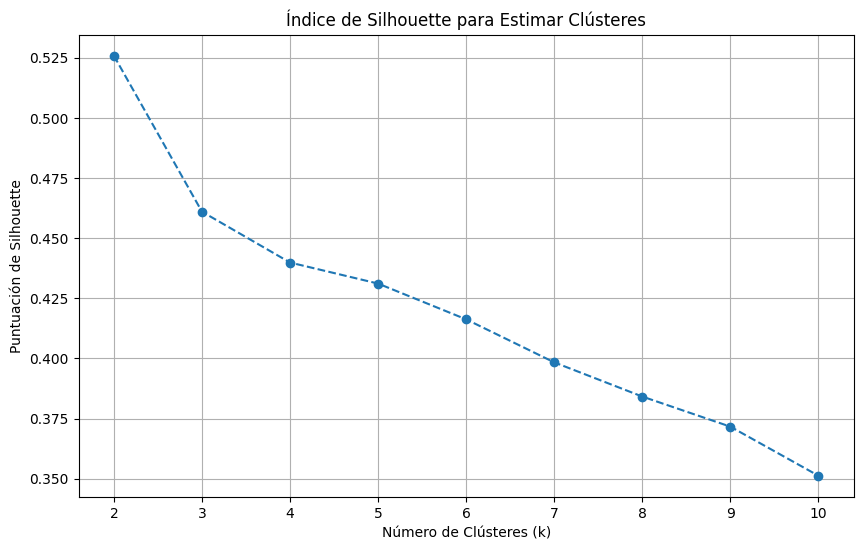

In [45]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
# El Silhouette Score requiere al menos 2 clústeres
for k in range(2, 11):
    kmeans_model = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans_model.fit(X_log_scaled)
    labels = kmeans_model.labels_
    score = silhouette_score(X_log_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Índice de Silhouette para Estimar Clústeres')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Puntuación de Silhouette')
plt.grid(True)
plt.show()

En este gráfico, la puntuación más alta se logra con k=2. Después de este punto, la puntuación disminuye significativamente, lo que sugiere que para 3, 4 o 5 clústeres, la calidad de la separación y la cohesión no es tan buena. La caída drástica a partir de k=2 indica que al dividir los datos en más grupos, se comienza a fragmentar clústeres coherentes o a crear grupos que están demasiado cerca unos de otros.

In [49]:
# Importar la clase KMeans, que ya tienes
from sklearn.cluster import KMeans

# Crear una instancia del modelo.
# n_clusters=5 le indica que queremos 5 grupos.
# random_state=0 asegura que los resultados sean reproducibles.
# n_init='auto' es una opción recomendada para inicializar el algoritmo.
kmeans = KMeans(n_clusters=2, random_state=0, n_init='auto')

# Entrenar el modelo. Scikit-learn encontrará los 5 centroides.
kmeans.fit(X_log_scaled)



KMeans(n_clusters=2, random_state=0)

In [50]:
# Obtener las etiquetas de los grupos para cada cliente
etiquetas_clusters = kmeans.labels_

# Agregar las etiquetas al DataFrame de clientes para su análisis
df_customer['Cluster'] = etiquetas_clusters

# Mostrar las primeras filas del DataFrame con la nueva columna 'Cluster'
print(df_customer.head())

   CustomerID  Quantity  TotalPrice  Quantity_log  TotalPrice_log  Cluster
0     12346.0     74215    77183.60     11.214735       11.253955        0
1     12347.0      2458     4310.00      7.807510        8.368925        0
2     12348.0      2341     1797.24      7.758761        7.494564        0
3     12349.0       631     1757.55      6.448889        7.472245        0
4     12350.0       197      334.40      5.288267        5.815324        1


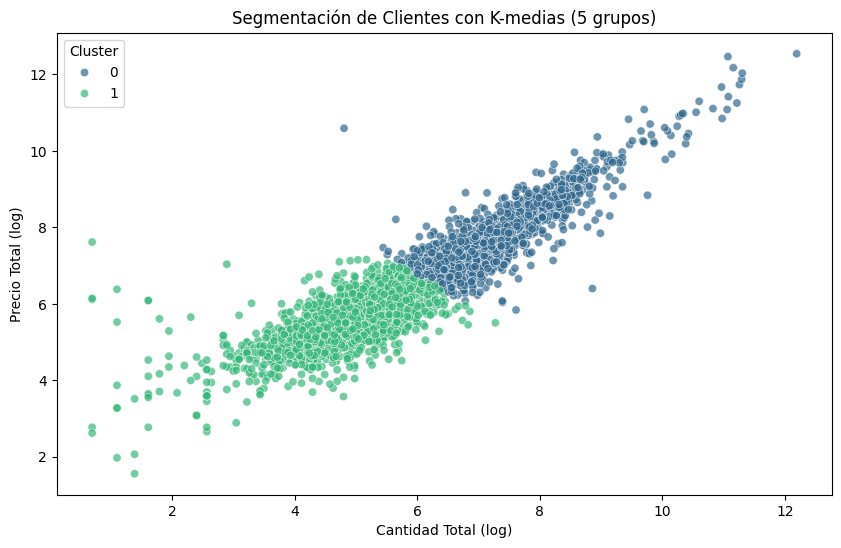

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crea un gráfico de dispersión con los datos log-transformados y estandarizados
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity_log', y='TotalPrice_log', hue='Cluster', data=df_customer, palette='viridis', alpha=0.7)
plt.title('Segmentación de Clientes con K-medias (5 grupos)')
plt.xlabel('Cantidad Total (log)')
plt.ylabel('Precio Total (log)')
plt.show()

##Analisis:

El modelo divide a los clientes en dos grupos principales, basándose en la cantidad total de artículos comprados y el gasto total. La separación entre estos dos clústeres es nítida, sin superposición significativa, lo que demuestra una distinción fundamental en el comportamiento de los clientes.

* **Clúster 0 (Morado): Clientes de bajo valor**

Este grupo se sitúa en la parte inferior izquierda del gráfico.

Sus características principales son una baja cantidad de compras y un gasto total bajo.

Este segmento representa a los clientes menos frecuentes o con menor compromiso, que probablemente han realizado pocas transacciones de pequeño importe.

* **Clúster 1 (Amarillo): Clientes de alto valor**

Este grupo se encuentra en la parte superior derecha del gráfico.

Se caracteriza por una alta cantidad de compras y un gasto total elevado.

Este es el segmento más valioso para la empresa. Estos clientes muestran un alto nivel de lealtad y compromiso, y son los que más contribuyen a los ingresos.